## Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.linear_model import LogisticRegression
from transformers import BartTokenizer, BartForConditionalGeneration
import string
from nltk.corpus import stopwords
from transformers import pipeline
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from wordcloud import WordCloud

## Downloading vader lexicon for sentiment analysis

In [2]:
# Downloading vader lexicon for sentiment analysis
print("Downloading vader lexicon...")
nltk.download('vader_lexicon')
print("\n")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alkis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Loading data

In [3]:
# Loading data
print("Loading data...")
data = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
print("\n")

Loading data...




# Exploratory Data Analysis (EDA)

In [4]:
# Check the first few rows of the data
data.head()

# Check for missing values in the data
data.isnull().sum()

print("Preprocessing data...")
# Remove rows with missing review text
data.dropna(subset=['Review Text'], inplace=True)

Preprocessing data...


## Plot the distribution of age among the reviewers

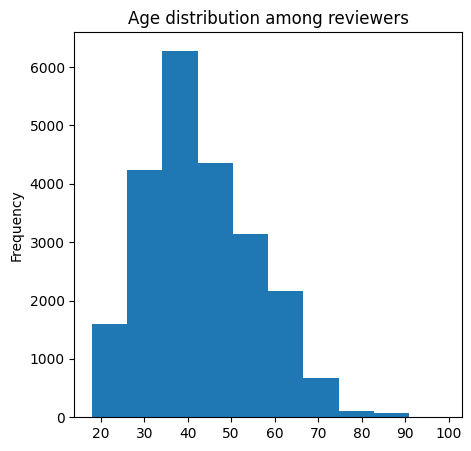

In [5]:
# Plot the distribution of age among the reviewers
plt.figure(figsize=(5,5))
data['Age'].plot(kind='hist')
plt.title('Age distribution among reviewers')
plt.show()
print("\n")

## Identify the top 5 most reviewed clothing items

In [6]:
# Identify the top 5 most reviewed clothing items
top_5_commented = data.groupby('Clothing ID')[['Rating']].count().sort_values(by='Rating',ascending=False).head(5)
top_5_commented.reset_index(inplace=True)
print(top_5_commented)
print("\n")

   Clothing ID  Rating
0         1078     987
1          862     778
2         1094     735
3         1081     561
4          872     519




## Plot the top 5 most reviewed clothing items

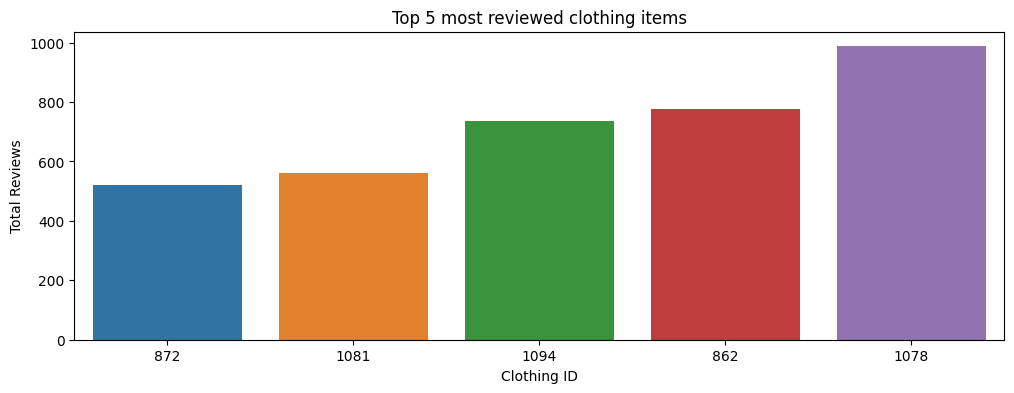

In [7]:
# Plot the top 5 most reviewed clothing items
plt.figure(figsize=(12,4))
sns.barplot(data=top_5_commented,x='Clothing ID',y='Rating',order=top_5_commented.sort_values('Rating')['Clothing ID'])
plt.xlabel('Clothing ID')
plt.ylabel('Total Reviews')
plt.title('Top 5 most reviewed clothing items')
plt.show()
print("\n")

## Find the total number of ratings per clothing item

In [8]:
# Find the total number of ratings per clothing item
total_ratings = data.groupby('Clothing ID')[['Rating']].count().sort_values(by='Rating',ascending=False)

## Display the total number of unique items reviewed

In [9]:
# Display the total number of unique items reviewed
total_ratings.shape
print("\n")

## Display the number of items that have only 1 or 2 reviews

In [10]:
# Display the number of items that have only 1 or 2 reviews
total_ratings[(total_ratings['Rating']==1) | (total_ratings['Rating']==2)].shape

(669, 1)

## Plot the distribution of the number of reviews per item

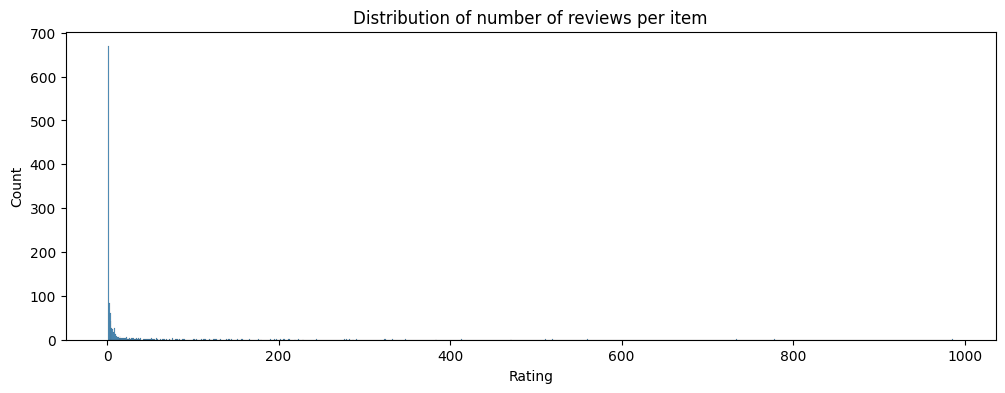

In [11]:
# Plot the distribution of the number of reviews per item
plt.figure(figsize=(12,4))
sns.histplot(data=total_ratings,x='Rating')
plt.title('Distribution of number of reviews per item')
plt.show()
print("\n")

## Plot the distribution of the number of reviews per item with a zoom in on items with fewer than 200 reviews

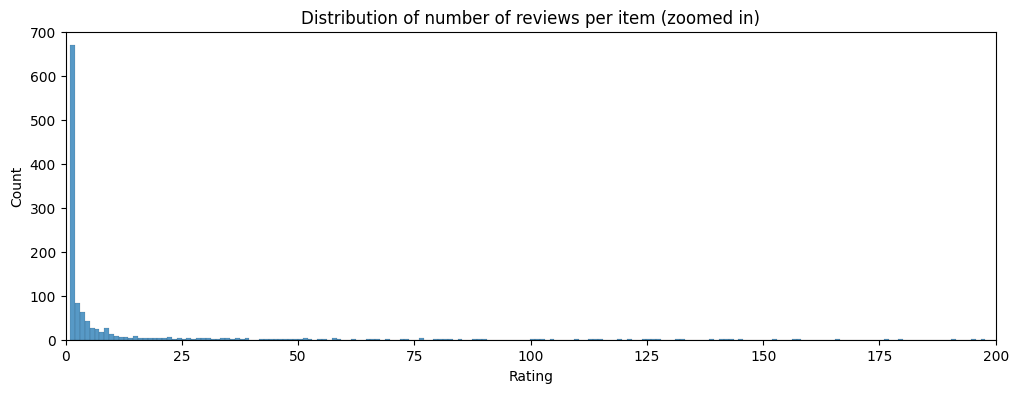

In [12]:
# Plot the distribution of the number of reviews per item with a zoom in on items with fewer than 200 reviews
plt.figure(figsize=(12,4))
sns.histplot(data=total_ratings,x='Rating')
plt.axis([0, 200, 0, 700])
plt.title('Distribution of number of reviews per item (zoomed in)')
plt.show()
print("\n")

## Find the best rated products with more than 10 reviews

In [13]:
# Find the best rated products with more than 10 reviews
index_over_10=total_ratings[total_ratings['Rating']>10].index
mean_ratings=data.groupby('Clothing ID')[['Rating']].mean().sort_values(by='Rating',ascending=False)

## To have a meaningful result we will get the average rating for clothes that have been reviewed over 10 times

In [14]:
# To have a meaningful result we will get the average rating for clothes that have been reviewed over 10 times
mean_over_10 = mean_ratings.loc[index_over_10].sort_values('Rating',ascending=False).head(10)
mean_over_10.reset_index(inplace=True)
print(mean_over_10)
print("\n")

   Clothing ID    Rating
0          252  4.818182
1         1026  4.800000
2          375  4.789474
3          260  4.785714
4          382  4.750000
5          906  4.735294
6          674  4.733333
7         1123  4.724138
8          621  4.692308
9          964  4.684932




## Plot the top 10 best rated clothing items with more than 10 reviews

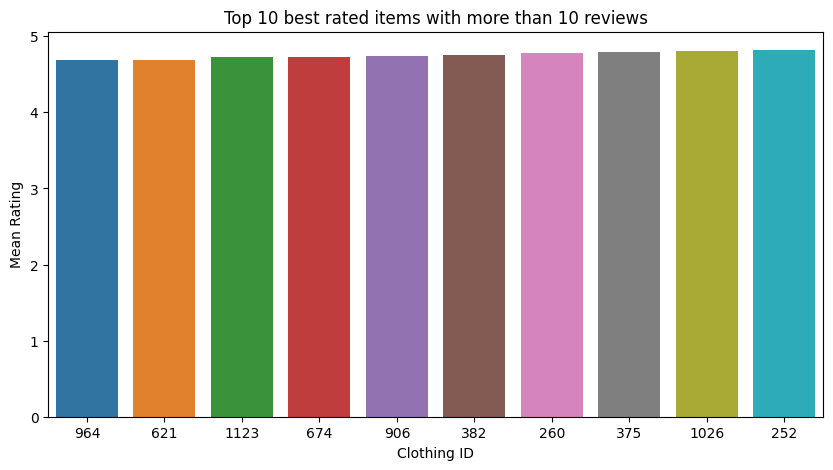

In [15]:
# Plot the top 10 best rated clothing items with more than 10 reviews
plt.figure(figsize=(10,5))
sns.barplot(data=mean_over_10,x='Clothing ID',y='Rating',order=mean_over_10.sort_values('Rating')['Clothing ID'])
plt.xlabel('Clothing ID')
plt.ylabel('Mean Rating')
plt.title('Top 10 best rated items with more than 10 reviews')
plt.show()
print("\n")

## Plot the count of reviews by clothing type

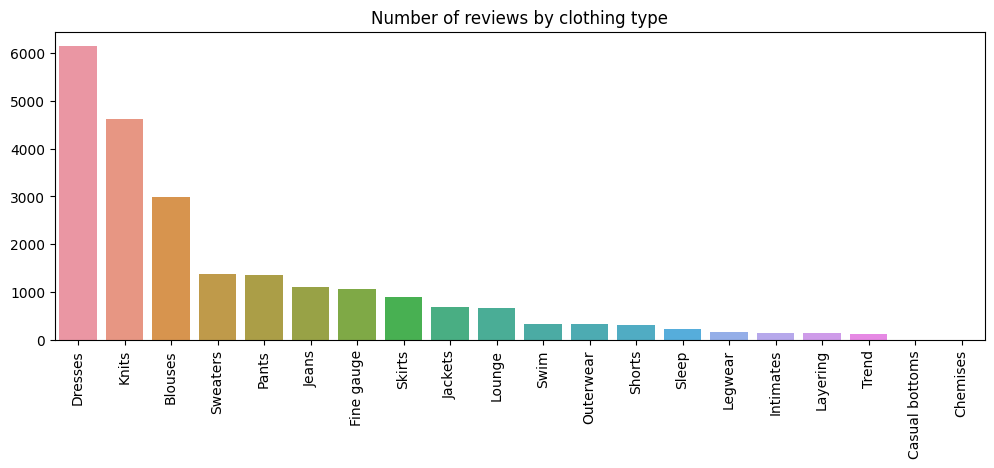

In [16]:
# Plot the count of reviews by clothing type
plt.figure(figsize=(12,4))
sns.barplot(x=list(data['Class Name'].value_counts().index),y=list(data['Class Name'].value_counts().values))
plt.xticks(rotation=90)
plt.title('Number of reviews by clothing type')
plt.show()
print("\n")

## Plot the count of reviews by department

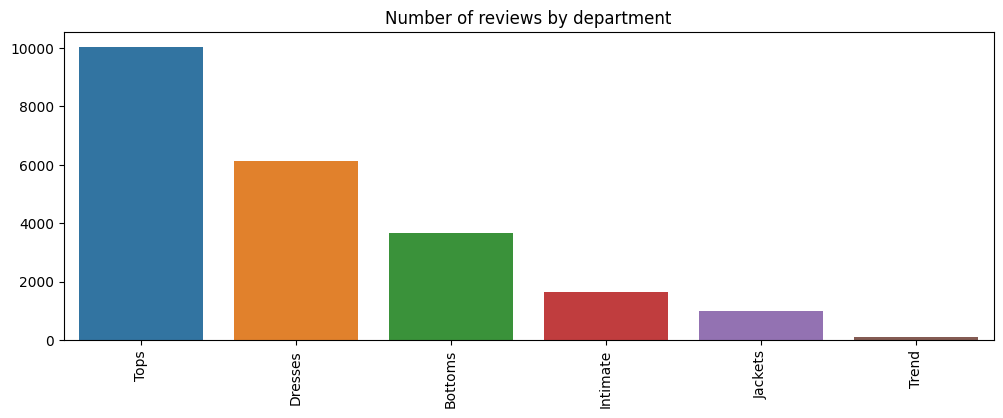

In [17]:
# Plot the count of reviews by department
plt.figure(figsize=(12,4))
sns.barplot(x=list(data['Department Name'].value_counts().index),y=list(data['Department Name'].value_counts().values))
plt.xticks(rotation=90)
plt.title('Number of reviews by department')
plt.show()
print("\n")

## Display the distribution of reviews by department as a pie chart

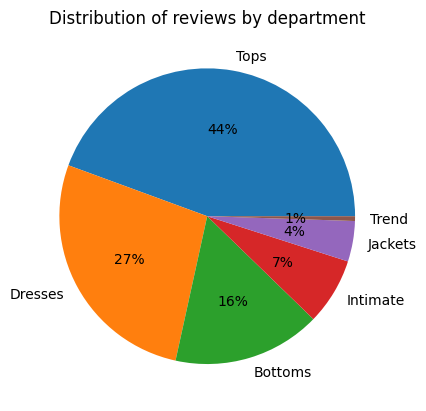

In [18]:
# Display the distribution of reviews by department as a pie chart
plt.pie(x=list(data['Department Name'].value_counts().values),labels=list(data['Department Name'].value_counts().index), autopct='%.0f%%')
plt.title('Distribution of reviews by department')
plt.show()
print("\n")

## Check the average word count in reviews by rating

In [19]:
# Check the average word count in reviews by rating
tokenizer = RegexpTokenizer(r'\w+')
data['lista']=data['Review Text'].apply(lambda x:tokenizer.tokenize(x))
data['len-lista']=data['lista'].apply(lambda x:len(x))

## Find the average word count in reviews by rating

In [20]:
# Find the average word count in reviews by rating
words = data.groupby('Rating')[['len-lista']].mean()

## Plot the average word count in reviews by rating

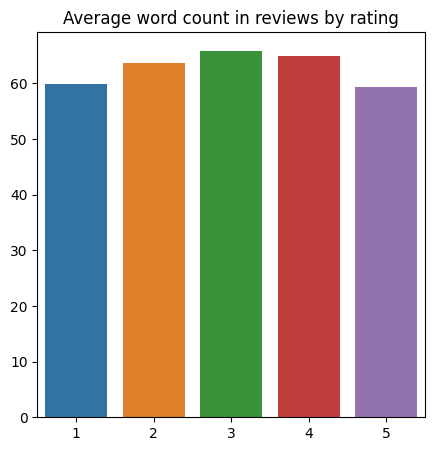

In [21]:
# Plot the average word count in reviews by rating
plt.figure(figsize=(5,5))
sns.barplot(x=list(words.index),y=list(words['len-lista'].values))
plt.title('Average word count in reviews by rating')
plt.show()
print("\n")

## Check the average punctuation count in reviews by rating

In [22]:
# Check the average punctuation count in reviews by rating
tokenizer = RegexpTokenizer(r'[^\w\s]')
data['punct']=data['Review Text'].apply(lambda x:tokenizer.tokenize(x))
data['len_punct']=data['punct'].apply(lambda x:len(x))
punct = data.groupby('Rating')[['len_punct']].mean()
print("\n")

## Plot the average punctuation count in reviews by rating

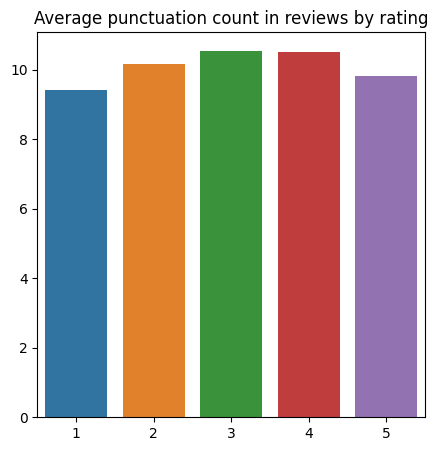

In [23]:
# Plot the average punctuation count in reviews by rating
plt.figure(figsize=(5,5))
sns.barplot(x=list(punct.index),y=list(punct['len_punct'].values))
plt.title('Average punctuation count in reviews by rating')
plt.show()
print("\n")

## Sentiment Analysis

In [24]:
print("Performing Sentiment Analysis...")
sid = SentimentIntensityAnalyzer()
df = data.copy()
df = df[['Review Text','Rating']]
df['compound']=df['Review Text'].apply(lambda x:sid.polarity_scores(x)['compound'])
df['new'] = df['compound'].apply(lambda x: 1 if x < -0.56586 else (2 if x >= -0.56586 and x < -0.17552 else (3 if x >= -0.17552 and x < 0.21482 else (4 if x >= 0.21482 and x < 0.60516 else 5))))
df['pos_neutral_negative'] = df['compound'].apply(lambda x: 'pos' if x >= 0.05 else 'neg' if x < -0.05 else 'neutral')
print("\n")

df.groupby('pos_neutral_negative')[['Rating']].mean()

Performing Sentiment Analysis...




,Rating
pos_neutral_negative,
neg,2.742733
neutral,3.136691
pos,4.291895


## Print the top 5 reviews with the highest sentiment score

In [25]:
# Print the top 5 reviews with the highest sentiment score
top_5_pos_texts = df.sort_values(by='compound',ascending=False)[['Review Text']].head(5)

for i in range(0,5):
    print(f'Positive comment ranked {i+1}')
    print(30*'---')
    print(top_5_pos_texts.iloc[i]['Review Text'])
    print(30*'---')
negative_5_pos_texts = df.sort_values(by='compound')[['Review Text']].head(5)

for i in range(0,5):
    print(f'Negative comment ranked {i+1}')
    print(30*'---')
    print(negative_5_pos_texts.iloc[i]['Review Text'])
    print(30*'---')

grouped_counts = df.groupby('pos_neutral_negative')['Rating'].value_counts().to_dict()
print(grouped_counts)
print("\n")

Positive comment ranked 1
------------------------------------------------------------------------------------------
This top is very gorgeous and chic. it is very tight at the bottom, but i feel like it will stretch a little over time, it is also very long which i love, because it can be rouched up to a great length if you are curvy. both colors are great, i bought both and love both. the sizing was correct, if you want it to fit like it does on the model shot. if you want it a little more fitted, size down, but it may be very tight on the bottom. all in all i love them and they are definitely a great find fo
------------------------------------------------------------------------------------------
Positive comment ranked 2
------------------------------------------------------------------------------------------
I saw this top online and fell in love with the overall casual look.
i ordered all 3 colors, and they just arrived........love love love !!!
they are soft, comfortable and a 

## Extracting Topics with LDA

In [26]:
print("Extracting Topics with LDA...")
n_topics = 5
n_top_words = 10
data_samples = df['Review Text'].values
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0)
lda.fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    message = "\nTopic #%d: " % topic_idx
    message += " ".join([tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)
print("\n")

Extracting Topics with LDA...

Topic #0: usual blouse sheer thing bra washed fabric trying suit wash

Topic #1: arrived money product hole cheap retailer disappointed hopes package taking

Topic #2: sweater sleeves warm pockets long soft weight wear coat like

Topic #3: love great color wear fit jeans comfortable perfect soft bought

Topic #4: dress size like fit small just fabric ordered love wear




## World Cloud from LDA Topic Extraction


Topic #0: usual blouse sheer thing bra washed fabric trying suit wash

Topic #1: arrived money product hole cheap retailer disappointed hopes package taking

Topic #2: sweater sleeves warm pockets long soft weight wear coat like

Topic #3: love great color wear fit jeans comfortable perfect soft bought

Topic #4: dress size like fit small just fabric ordered love wear


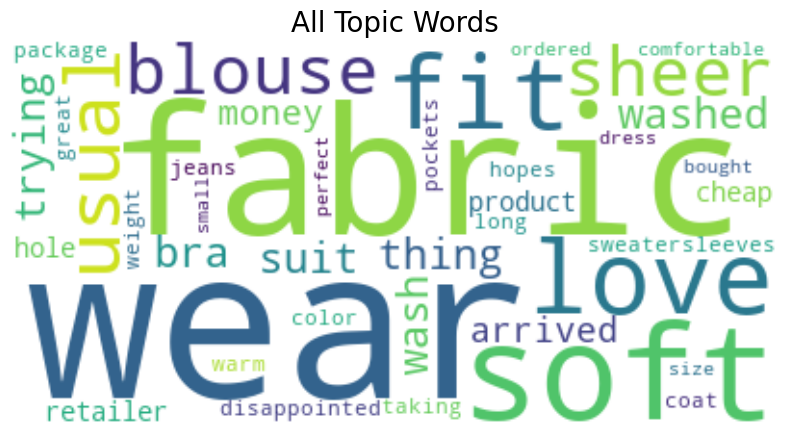

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_topic_words = []

for topic_idx, topic in enumerate(lda.components_):
    words = [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    all_topic_words.extend(words)
    message = "\nTopic #%d: " % topic_idx
    message += " ".join(words)
    print(message)

# Create a word cloud for all topic words
wc = WordCloud(background_color="white", max_words=1000)
wordcloud = wc.generate(' '.join(all_topic_words))

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('All Topic Words', size=20)
plt.show()

## Extracting Topics with NMF

In [27]:
print("Extracting Topics with NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_samples)
nmf = NMF(n_components=n_topics, random_state=1).fit(tfidf)
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf.components_):
    message = "\nTopic #%d: " % topic_idx
    message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)
print("\n")

Extracting Topics with NMF...

Topic #0: size small large medium ordered runs usually fit wear true

Topic #1: dress beautiful flattering love perfect slip wear comfortable dresses summer

Topic #2: love great jeans comfortable perfect soft wear color pants sweater

Topic #3: like just really fabric look nice good didn color fit

Topic #4: shirt cute super white little material boxy really underneath soft




## Wordcloud from NMF Topic Extraction


Topic #0: size small large medium ordered runs usually fit wear true

Topic #1: dress beautiful flattering love perfect slip wear comfortable dresses summer

Topic #2: love great jeans comfortable perfect soft wear color pants sweater

Topic #3: like just really fabric look nice good didn color fit

Topic #4: shirt cute super white little material boxy really underneath soft


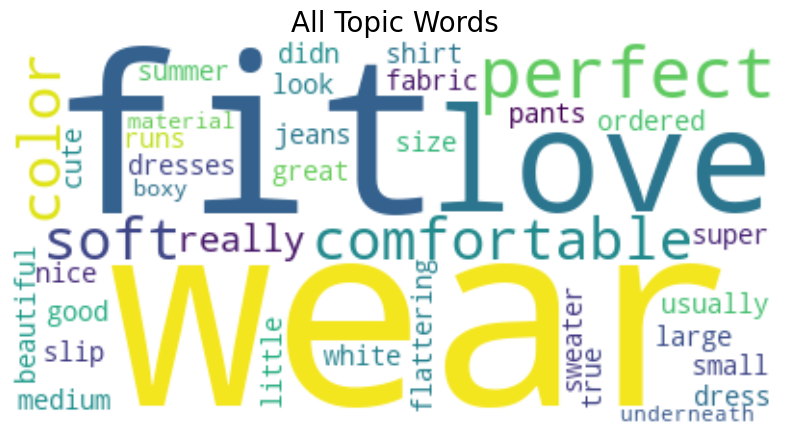

In [52]:
all_topic_words = []

for topic_idx, topic in enumerate(nmf.components_):
    words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    all_topic_words.extend(words)
    message = "\nTopic #%d: " % topic_idx
    message += " ".join(words)
    print(message)

# Create a word cloud for all topic words
wc = WordCloud(background_color="white", max_words=1000)
wordcloud = wc.generate(' '.join(all_topic_words))

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('All Topic Words', size=20)
plt.show()


## Summarizing text with BART

In [28]:
print("Summarizing text with BART...")
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
def summarize_text(text):
    inputs = tokenizer.encode("summarize: " + text, return_tensors='pt', max_length=1024, truncation=True)
    outputs = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0])
sample_text = df['Review Text'][2]
summary = summarize_text(sample_text)
print(f"\nOriginal: {sample_text}")
print(f"\nSummary: {summary}")
print("\n")

Summarizing text with BART...

Original: I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c

Summary: </s><s>The top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper.</s>




## Perform Sentiment Analysis with Logistic Regression


Performing grid search...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best score: 0.935
Best parameters set:
	clf__C: 10
	vect__max_df: 0.5
Accuracy: 0.9375137999558402


Classification Report:
              precision    recall  f1-score   support

         neg       0.66      0.27      0.38       276
     neutral       0.00      0.00      0.00        45
         pos       0.94      0.99      0.97      4208

    accuracy                           0.94      4529
   macro avg       0.53      0.42      0.45      4529
weighted avg       0.92      0.94      0.92      4529


Confusion Matrix:


/Users/alkis/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


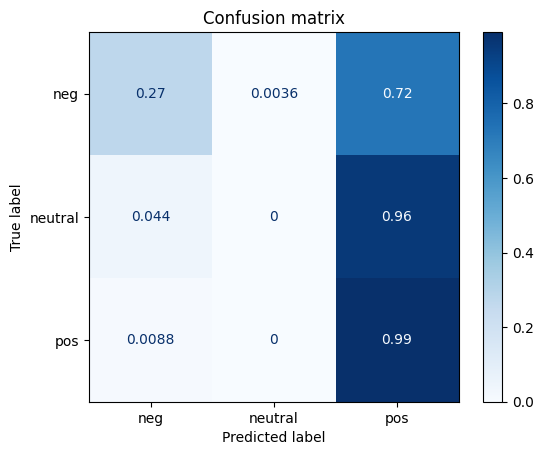

In [29]:
# Define a pipeline that combines a text feature extractor with a simple classifier
pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(solver='liblinear')),
])

# Define grid search
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'clf__C': (0.01, 0.1, 1, 10),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring = "accuracy", refit=True, cv=5)

print("\nPerforming grid search...")
# Change target to 'pos_neutral_negative'
X_train, X_test, y_train, y_test = train_test_split(df['Review Text'], df['pos_neutral_negative'], test_size=0.2, random_state=42)
grid_search.fit(X_train, y_train)

print("\nBest score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

y_pred = grid_search.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
disp = plot_confusion_matrix(grid_search, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title('Confusion matrix')
plt.show()
##########

## Up-sampling Minority Class | TF-IDF (Term Frequency-Inverse Document Frequency)

Resampled dataset shape Counter({'pos': 16779, 'neg': 16779, 'neutral': 16779})
Accuracy: 0.8690660189887393

Classification Report:
              precision    recall  f1-score   support

         neg       0.33      0.66      0.44       276
     neutral       0.08      0.27      0.13        45
         pos       0.98      0.89      0.93      4208

    accuracy                           0.87      4529
   macro avg       0.46      0.61      0.50      4529
weighted avg       0.93      0.87      0.89      4529


Confusion Matrix:


/Users/alkis/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


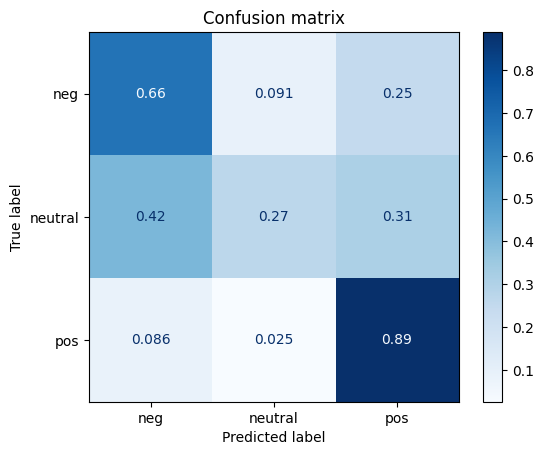

In [30]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the vectorizer on the training data
X_train_vec = vectorizer.fit_transform(X_train)

# Only transform the test data
X_test_vec = vectorizer.transform(X_test)

# Up-sampling Minority Class
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train_vec, y_train)
print('Resampled dataset shape %s' % Counter(y_ros))

# Fitting a logistic regression model
clf_ros = LogisticRegression(solver='liblinear', class_weight='balanced')
clf_ros.fit(X_ros, y_ros)

# Predictions and Evaluations
y_pred_ros = clf_ros.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred_ros))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ros))

print("\nConfusion Matrix:")
disp = plot_confusion_matrix(clf_ros, X_test_vec, y_test, cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title('Confusion matrix')
plt.show()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
clf_ros = LogisticRegression(solver='liblinear', class_weight='balanced')
clf_ros.fit(X_ros, y_ros)
y_pred_ros = clf_ros.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred_ros))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ros))
while True:
    # Get user input (fresh review)
    input_text = input("Enter text: ")

    # Transform the input using the vectorizer
    input_vec = vectorizer.transform([input_text])

    # Predict the sentiment
    sentiment_pred = clf_ros.predict(input_vec)

    # Convert the predicted class label to sentiment label
    predicted_sentiment = sentiment_pred[0]

    print(f"Predicted sentiment: {predicted_sentiment}\n")


Accuracy: 0.8690660189887393

Classification Report:
              precision    recall  f1-score   support

         neg       0.33      0.66      0.44       276
     neutral       0.08      0.27      0.13        45
         pos       0.98      0.89      0.93      4208

    accuracy                           0.87      4529
   macro avg       0.46      0.61      0.50      4529
weighted avg       0.93      0.87      0.89      4529

Enter text: As another reviewer wrote.. this is not the same jean featured on the website. same cut and style but it's a light denim wash with wiskering and worn look at the knees. i called customer service to see if this was a mistake and they said there was not really a way to check it unless i exchanged them. i didnt want the same wrong jeans again so i opted out ... too bad they are cure.
Predicted sentiment: neg

Enter text: Horrible fir, will return
Predicted sentiment: neg

Enter text: mediocre but like the color
Predicted sentiment: pos

Enter text: Not sure, bought 2 items, not very impressive
Predicted sentiment: neg

Enter text: Love it. So perfect.
Predicted sentiment: pos

# FLAN-T5-BASE

## Used with our input

In [31]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Instantiate the model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

# Define a function for question answering
def answer_question(code_snippet, question):
    """
    Takes a code snippet and question as input,
    and prints the model's answer.
    """
    # Combine the code and question into a single string
    input_text = f"Code:\n{code_snippet}\nQuestion:\n{question}"

    # Tokenize the input text
    inputs = tokenizer(input_text, truncation=True, max_length=512, return_tensors="pt")

    # Generate output from the model
    outputs = model.generate(inputs["input_ids"], max_length=512, num_beams=5)

    # Decode the output to get the answer
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Print the answer in a conversational format
    print(f"Based on the text, it appears that {answer}")

# Use the function to answer a question
code_snippet = """
As another reviewer wrote.. this is not the same jean featured on the website. same cut and style but it's a light denim wash with wiskering and worn look at the knees. i called customer service to see if this was a mistake and they said there was not really a way to check it unless i exchanged them. i didnt want the same wrong jeans again so i opted out ... too bad they are cure.
"""
question = "Did the customer call customer service?"
answer_question(code_snippet, question)


Based on the text, it appears that i called customer service to see if this was a mistake and they said there was not really a way to check it unless i exchanged them. i didn't want the same wrong jeans again so i opted out... too bad they are cure.


In [32]:
code_snippet = """
def calculate_area(length, width):
    return length * width
"""
question = "What does the calculate_area function do?"
answer_question(code_snippet, question)

Based on the text, it appears that return length * width


In [33]:
code_snippet = """
def calculate_area(length, width):
    return length * width
"""
question = "Can the calculate_area function handle non-integer values for length and width?"
answer_question(code_snippet, question)

Based on the text, it appears that yes


In [34]:
# Use the function to answer a question
code_snippet = """
 I had such high hopes for this dress and really wanted it to work for me.
 i initially ordered the petite small (my usual size) but i found this to be 
 outrageously small. so small in fact that i could not zip it up! i reordered it 
 in petite medium, which was just ok. overall, the top half was comfortable and 
 fit nicely, but the bottom half had a very tight under layer and several somewhat 
 cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c"""
question = "What is the topic?"
answer_question(code_snippet, question)

Based on the text, it appears that dress for valentine's day


## Review for Sentiment Extraction with Flan

In [41]:
# Use the function to answer a question
code_snippet = """
 I had such high hopes for this dress and really wanted it to work for me.
 i initially ordered the petite small (my usual size) but i found this to be 
 outrageously small. so small in fact that i could not zip it up! i reordered it 
 in petite medium, which was just ok. overall, the top half was comfortable and 
 fit nicely, but the bottom half had a very tight under layer and several somewhat 
 cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c"""
question = "What is the sentiment?"
answer_question(code_snippet, question)

Based on the text, it appears that negative


# FLAN-T5-BASE

## Used on questioning

In [35]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Instantiate the model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

# Define a function for question answering
def answer_question2(question):
    """
    Takes a question as input and prints the model's answer.
    """
    # Tokenize the input text
    inputs = tokenizer(question, truncation=True, max_length=512, return_tensors="pt")

    # Generate output from the model
    outputs = model.generate(inputs["input_ids"], max_length=512, num_beams=5)

    # Decode the output to get the answer
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Print the answer
    print("Answer:", answer)

# Use the function to answer a question
question = "Write a tagline for the AI"
answer_question2(question)

Answer: The AI's mission is to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to make the world a better place to live, and to mak

In [36]:
# Use the function to answer a question
question = "What is the name of the sea around Greece?"
answer_question2(question)

Answer: aegean sea


In [37]:
# Use the function to answer a question
question = "How are you doing today?"
answer_question2(question)

Answer: I'm fine.


In [38]:
# Use the function to answer a question
question = "Who was president of U.S that got assassinated?"
answer_question2(question)

Answer: john f kennedy


In [39]:
# Use the function to answer a question
question = "When did world war 2 started?"
answer_question2(question)

Answer: 1939


# DataFrameChatBot

In [40]:
import spacy
import pandas as pd

class DataFrameChatBot:
    def __init__(self, df):
        self.df = df
        self.nlp = spacy.load("en_core_web_sm")

    def get_columns(self):
        return self.df.columns.tolist()

    def get_shape(self):
        return self.df.shape

    def get_column_type(self, column_name):
        if column_name in self.df.columns:
            return str(self.df[column_name].dtypes)
        else:
            return f"No column named {column_name} exists in the dataframe."

    def get_nulls_in_column(self, column_name):
        if column_name in self.df.columns:
            return self.df[column_name].isnull().sum()
        else:
            return f"No column named {column_name} exists in the dataframe."

    def get_summary(self):
        return str(self.df.describe())

    def get_mean(self, column_name):
        if column_name in self.df.columns:
            return self.df[column_name].mean()
        else:
            return f"No column named {column_name} exists in the dataframe."

    def get_sum(self, column_name):
        if column_name in self.df.columns:
            return self.df[column_name].sum()
        else:
            return f"No column named {column_name} exists in the dataframe."

    def get_max(self, column_name):
        if column_name in self.df.columns:
            return self.df[column_name].max()
        else:
            return f"No column named {column_name} exists in the dataframe."

    def get_min(self, column_name):
        if column_name in self.df.columns:
            return self.df[column_name].min()
        else:
            return f"No column named {column_name} exists in the dataframe."

    def get_unique_count(self, column_name):
        if column_name in self.df.columns:
            return self.df[column_name].nunique()
        else:
            return f"No column named {column_name} exists in the dataframe."

    def column_exists(self, column_name):
        return column_name in self.df.columns

    def get_correlation(self, column_name1, column_name2):
        if column_name1 in self.df.columns and column_name2 in self.df.columns:
            return self.df[column_name1].corr(self.df[column_name2])
        else:
            return f"Check if both {column_name1} and {column_name2} exist in the dataframe."

    def column_has_nulls(self, column_name):
        if column_name in self.df.columns:
            return self.df[column_name].isnull().any()
        else:
            return f"No column named {column_name} exists in the dataframe."

    def get_most_frequent(self, column_name):
        if column_name in self.df.columns:
            return self.df[column_name].value_counts().idxmax()
        else:
            return f"No column named {column_name} exists in the dataframe."

    def process_question(self, question):
        doc = self.nlp(question.lower())
        
        if 'column' in [token.lemma_ for token in doc]:
            column_names = [column for column in self.df.columns if column.lower() in question.lower()]

            if not column_names:
                return "Please mention the column name in your question."

            if 'type' in [token.lemma_ for token in doc]:
                return self.get_column_type(column_names[0])
            elif 'null' in question.lower() or 'missing' in question.lower():
                return self.get_nulls_in_column(column_names[0])
            elif 'average' in question.lower() or 'mean' in question.lower():
                return self.get_mean(column_names[0])
            elif 'total' in question.lower() or 'sum' in question.lower():
                return self.get_sum(column_names[0])
            elif 'maximum' in question.lower() or 'max' in question.lower():
                return self.get_max(column_names[0])
            elif 'minimum' in question.lower() or 'min' in question.lower():
                return self.get_min(column_names[0])
            elif 'unique' in question.lower():
                return self.get_unique_count(column_names[0])
            elif 'exist' in question.lower():
                return self.column_exists(column_names[0])
            elif 'correlation' in question.lower():
                if len(column_names) >= 2:
                    return self.get_correlation(column_names[0], column_names[1])
            elif 'has null' in question.lower():
                return self.column_has_nulls(column_names[0])
            elif 'most frequent' in question.lower() or 'mode' in question.lower():
                return self.get_most_frequent(column_names[0])
        elif 'row' in [token.lemma_ for token in doc] and ('how many' in question.lower() or 'number of' in question.lower()):
            return self.get_shape()[0]
        elif 'summary' in question.lower():
            return self.get_summary()

        return "Sorry, I did not understand your question."


# Assuming 'data' is your DataFrame
data = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

chatbot = DataFrameChatBot(data)

questions = [
    "What is the type of the Title column?",
    "How many null values are in the Age column?",
    "What is the average of the Age column?",
    "What is the total sum of the Age column?",
    "What is the maximum value in the Age column?",
    "What is the minimum value in the Age column?",
    "How many unique values are in the Age column?",
    "Does the Age column exist?",
    "What is the correlation between Age and Salary columns?",
    "Does the Age column has null values?",
    "What is the most frequent category in the Age column?",
    "Can I have a summary of the dataframe?",
    "What is the type of the Rating column?",
    "How many unique values are in the Division Name column?",
    "Does the Recommended IND column have any null values?",
    "What is the most frequent category in the Class Name column?",
    "What is the correlation between Rating and Recommended IND columns?"
]

for question in questions:
    print(f"Q: {question}")
    print(f"A: {chatbot.process_question(question)}")
    print("---")


Q: What is the type of the Title column?
A: object
---
Q: How many null values are in the Age column?
A: 0
---
Q: What is the average of the Age column?
A: 43.198543813335604
---
Q: What is the total sum of the Age column?
A: 1014561
---
Q: What is the maximum value in the Age column?
A: 99
---
Q: What is the minimum value in the Age column?
A: 18
---
Q: How many unique values are in the Age column?
A: 77
---
Q: Does the Age column exist?
A: True
---
Q: What is the correlation between Age and Salary columns?
A: Sorry, I did not understand your question.
---
Q: Does the Age column has null values?
A: 0
---
Q: What is the most frequent category in the Age column?
A: 39
---
Q: Can I have a summary of the dataframe?
A:          Unnamed: 0   Clothing ID           Age        Rating  \
count  23486.000000  23486.000000  23486.000000  23486.000000   
mean   11742.500000    918.118709     43.198544      4.196032   
std     6779.968547    203.298980     12.279544      1.110031   
min        0.00